In [ ]:
## Data Exploration & Aggregation

In [ ]:
# Load CSV – lettura + quick peek

In [ ]:
import pandas as pd
# Path file
df = pd.read_csv("/home/vittof1/workspace/python-pro-sprint/data/processed/Bahrain_2025_R_processed.csv")
df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds,LapInStint,StintAvgPaceSeconds,StintAvgPace,DeltaToStintAvgSeconds
0,0 days 00:57:13.827000,PIA,81,0 days 00:01:38.693000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:42.130000,...,1.0,False,NaN,False,False,98.693,1,98.642143,1:38.642,0.050857
1,0 days 00:58:51.319000,PIA,81,0 days 00:01:37.492000,2.0,1.0,NaN,NaN,0 days 00:00:31.139000,0 days 00:00:42.343000,...,1.0,False,NaN,False,True,97.492,2,98.642143,1:38.642,-1.150143
2,0 days 01:00:29.402000,PIA,81,0 days 00:01:38.083000,3.0,1.0,NaN,NaN,0 days 00:00:31.306000,0 days 00:00:42.727000,...,1.0,False,NaN,False,True,98.083,3,98.642143,1:38.642,-0.559143
3,0 days 01:02:07.535000,PIA,81,0 days 00:01:38.133000,4.0,1.0,NaN,NaN,0 days 00:00:31.326000,0 days 00:00:42.796000,...,1.0,False,NaN,False,True,98.133,4,98.642143,1:38.642,-0.509143
4,0 days 01:03:45.578000,PIA,81,0 days 00:01:38.043000,5.0,1.0,NaN,NaN,0 days 00:00:31.305000,0 days 00:00:42.690000,...,1.0,False,NaN,False,True,98.043,5,98.642143,1:38.642,-0.599143


In [ ]:
# Aggregate by Compound — Average lap times

In [ ]:
# Average lap times (s) per compound
compound_mean = df.groupby(["Compound"])["LapTimeSeconds"].mean()
print(compound_mean)


Compound
HARD      101.833248
MEDIUM    100.543125
SOFT      100.483722
Name: LapTimeSeconds, dtype: float64


In [ ]:
# Aggregate by Stint — Lap counting

In [ ]:
# Lap count per driver/stint
laps_per_stint = df.groupby(["Driver", "Stint"]).size()
print(laps_per_stint)


Driver  Stint
ALB     1.0      16
        2.0      16
        3.0      25
ALO     1.0      16
        2.0      16
                 ..
TSU     2.0      21
        3.0      25
VER     1.0      10
        2.0      16
        3.0      31
Length: 62, dtype: int64


In [ ]:
## Tyre Degradation Modeling

In [ ]:
# Write deg_params.yaml

In [ ]:
from pathlib import Path
import json
import yaml

# Tire degradation model
# Lap time is expressed as: lap_time = base + a*sqrt(laps) + b*laps
# where:
# - base = baseline lap time
# - a = coefficient for non-linear degradation (square root term)
# - b = coefficient for linear degradation (per lap)

# Dictionary containing the degradation parameters for each tire compound
deg_params = {
    "Soft": {"a": 0.05, "b": 0.01},
    "Medium": {"a": 0.03, "b": 0.008},
    "Hard": {"a": 0.02, "b": 0.005}
}

# Output path
output_file = Path("fastf1-toolbox/inputs/deg_params.yaml")

# Ensure that the parent directory exists; create it if necessary
output_file.parent.mkdir(exist_ok=True, parents=True)

# Write the degradation parameters dictionary to the YAML file
with open(output_file, 'w') as f:
    yaml.safe_dump(
        deg_params,
        f,
        sort_keys=True,        # Keep keys sorted for readability
        indent=2,              # Indentation for a clean structure
        default_flow_style=False # Use block style (more human-readable)
    )


In [ ]:
# Theoretical Tyre degradation model

In [ ]:
import numpy as np

# Function: Compute the lap time for a given tire compound and lap number within a stint.
def tyre_lap_time(compound, lap_in_stint):
    base = 90 # Baseline lap time in seconds

    # Soft compound case
    if compound == "Soft":
        A = deg_params["Soft"]["a"]     # Extract non-linear degradation parameter
        B = deg_params["Soft"]["b"]     # Extract linear degradation parameter
        lap_time = base + A * np.sqrt(lap_in_stint) + B * lap_in_stint
        return A, B, lap_time

    # Medium compound case
    if compound == "Medium":
        A = deg_params["Medium"]["a"]
        B = deg_params["Medium"]["b"]
        lap_time = base + A * np.sqrt(lap_in_stint) + B * lap_in_stint
        return A, B, lap_time

    # Hard compound case
    if compound == "Hard":
        A = deg_params["Hard"]["a"]
        B = deg_params["Hard"]["b"]
        lap_time = base + A * np.sqrt(lap_in_stint) + B * lap_in_stint
        return A, B, lap_time

# Example usage:
# Compute lap time for the Soft compound on lap 13 of the stint
print(tyre_lap_time("Soft", 13))
   

(0.05, 0.01, 90.3102775637732)


In [ ]:
# Degradation curves

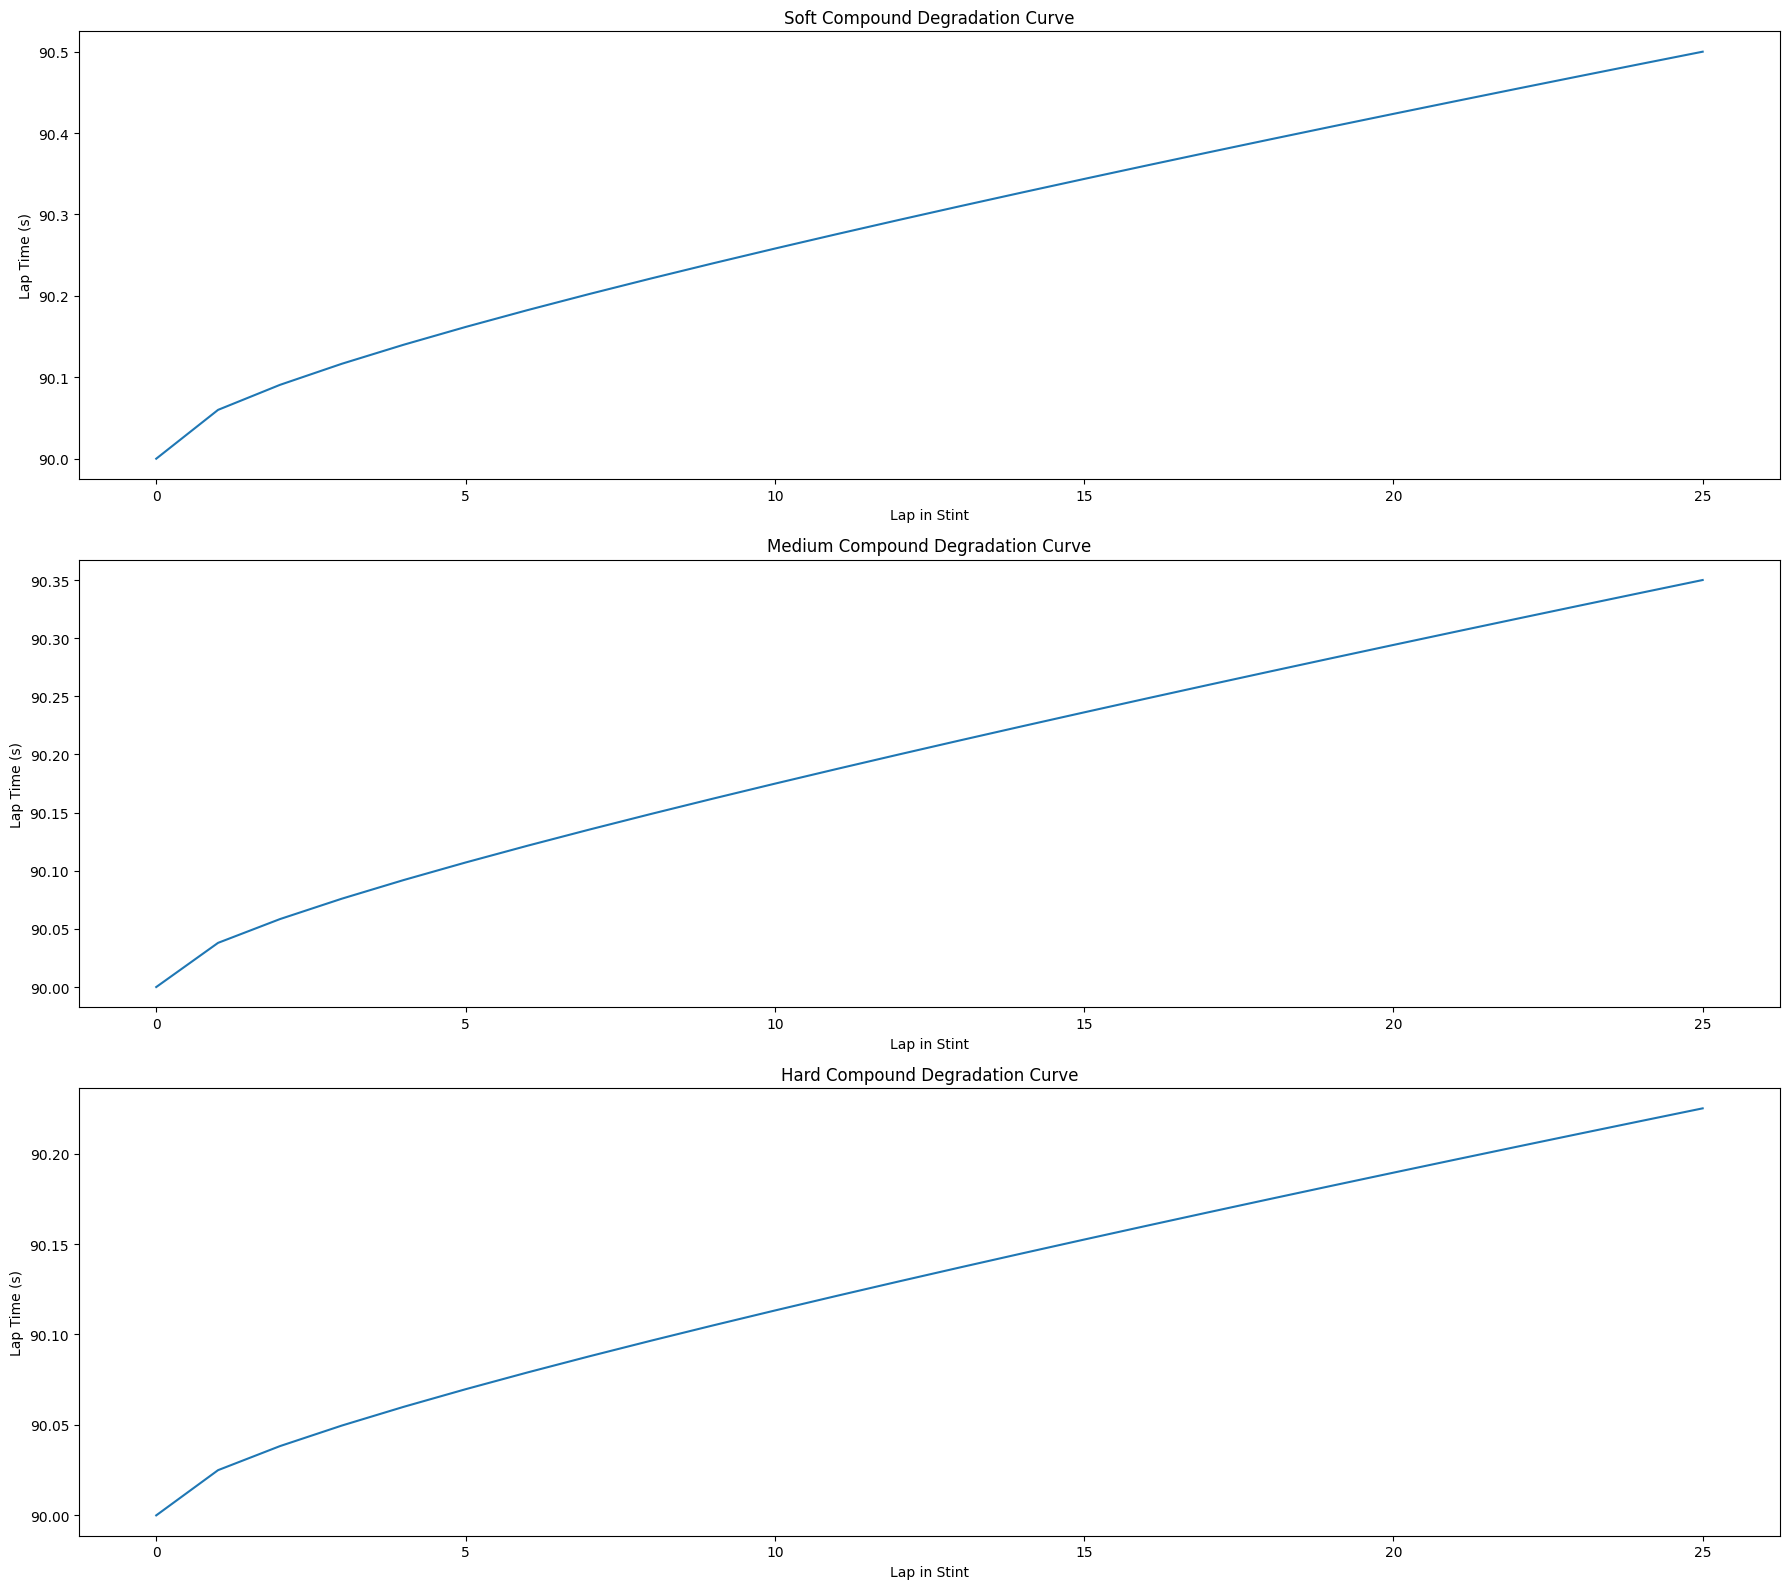

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0, 26) 
# Create an array representing the laps within a stint (0 to 25).
# 26 is chosen because it approximates the average stint length across the three compounds for all drivers

# Compute lap times for each compound by extracting the 3rd return value (lap_time) from tyre_lap_time()
time_soft = [tyre_lap_time("Soft", lap)[2] for lap in t]
time_medium = [tyre_lap_time("Medium", lap)[2] for lap in t]
time_hard = [tyre_lap_time("Hard", lap)[2] for lap in t]

# Block: Create the figure with 3 subplots (stacked vertically)
fig, ax = plt.subplots(3, 1, figsize=(18, 16))

# 1) Soft compound degradation curve
ax[0].plot(t, time_soft)
ax[0].set_xlabel("Lap in Stint")
ax[0].set_ylabel("Lap Time(s)")
ax[0].set_title("Soft Compound Degradation Curve")

# 2) Medium compound degradation curve
ax[1].plot(t, time_medium)
ax[1].set_xlabel("Lap in Stint")
ax[1].set_ylabel("Lap Time(s)")
ax[1].set_title("Medium Compound Degradation Curve")

# 3) Hard compound degradation curve
ax[2].plot(t, time_hard)
ax[2].set_xlabel("Lap in Stint")
ax[2].set_ylabel("Lap Time(s)")
ax[2].set_title("Hard Compound Degradation Curve")

# Adjust spacing between plots to avoid overlapping titles/labels
plt.tight_layout()

# Save the figure to file for later use in reports or dashboards
fig.savefig("tyre_degradation_plot.png")

# Display the plots interactively
plt.show()


In [ ]:
## Strategy Simulation & Monte Carlo Analysis

In [ ]:
# Function: Simulate the total time (in seconds) of a stint with a given tire compound
def simulate_stint(compound, laps):
    total_time = 0.0  # accumulator for the total stint time

    # Loop over each lap in the stint
    for lap_idx in range(laps):
        # The 3rd element ([2]) of 'tyre_lap_time' function corresponds to the lap time in seconds.
        laptime = tyre_lap_time(compound, lap_idx)[2]
        # Add current lap time to the cumulative total
        total_time += laptime
    return total_time  # total time (in seconds) for the full stint


# Example usage: simulate 3 laps on Soft tires
print(simulate_stint("Soft", 3))       

270.1507106781187


In [ ]:
# Monte Carlo Strategies

In [ ]:
import numpy as np

# Function: Monte Carlo simulation for a 1-stop strategy: Soft → Medium.
# The driver starts on Soft tires, pits randomly between laps 12–15,
# then finishes the race on Mediums. The full race length is 57 laps
def run_monte_carlo_soft_medium():
    final_times = []
    n = 0
    while n < 10000:
        # Sample the pit stop lap uniformly between 12 and 15 inclusive
        lap_pit = np.random.randint(12, 16)

        # Remaining laps after the pit stop
        remain_laps = 57 - lap_pit

        # Simulate first stint on Soft, then Medium
        s = simulate_stint("Soft", lap_pit)
        m = simulate_stint("Medium", remain_laps)

        # Total race time = sum of stints
        total_times = s + m

        # Store result for this simulation
        final_times.append(total_times)
        n += 1

    return final_times  # List of total race times (in seconds) for 10,000 simulated races


# Function: Monte Carlo simulation for a 1-stop strategy: Soft → Hard
# The driver starts on Soft tires, pits randomly between laps 10–11,
# then finishes the race on Hards. The full race length is 57 laps
def run_monte_carlo_soft_hard():
    final_times = []
    n = 0
    while n < 10000:
        # Pit stop lap sampled uniformly between 10 and 11 inclusive
        lap_pit = np.random.randint(10, 12)
        remain_laps = 57 - lap_pit

        s = simulate_stint("Soft", lap_pit)
        h = simulate_stint("Hard", remain_laps)
        total_times = s + h

        final_times.append(total_times)
        n += 1

    return final_times


# Function: Monte Carlo simulation for a 1-stop strategy: Medium → Hard.
# The driver starts on Medium tires, pits randomly between laps 15–19,
# then finishes the race on Hards. The full race length is 57 laps
def run_monte_carlo_medium_hard():
    final_times = []
    n = 0
    while n < 10000:
        # Pit stop lap sampled uniformly between 15 and 19 inclusive
        lap_pit = np.random.randint(15, 20)
        remain_laps = 57 - lap_pit

        m = simulate_stint("Medium", lap_pit)
        h = simulate_stint("Hard", remain_laps)
        total_times = m + h

        final_times.append(total_times)
        n += 1

    return final_times

    

In [ ]:
# Monte Carlo Strategy Histograms

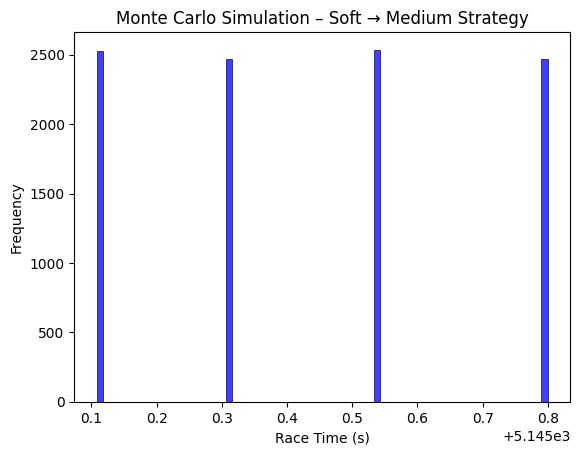

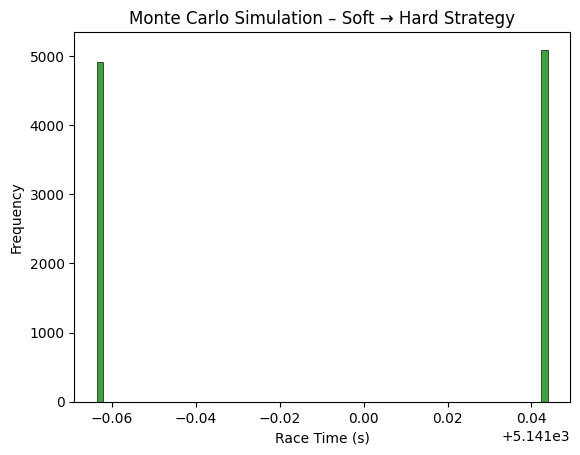

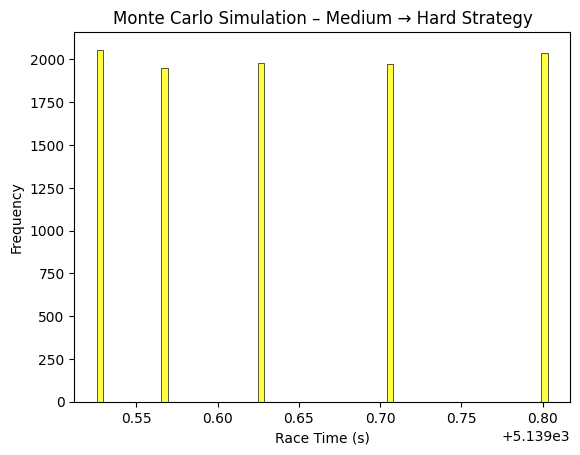

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Block: Histograms
# 1) Histogram: Soft → Medium strategy
A = sns.histplot(run_monte_carlo_soft_medium(), bins=70, color="blue")
A.set_xlabel("Race Time (s)")      # X-axis: total race time in seconds
A.set_ylabel("Frequency")          # Y-axis: how many simulations fall in each bin
A.set_title("Monte Carlo Simulation – Soft → Medium Strategy")
plt.savefig("M.C.Simulation – Soft → Medium Strategy.png")
plt.show()

# 2) Histogram: Soft → Hard strategy
B = sns.histplot(run_monte_carlo_soft_hard(), bins=70, color="green")
B.set_xlabel("Race Time (s)")
B.set_ylabel("Frequency")
B.set_title("Monte Carlo Simulation – Soft → Hard Strategy")
plt.savefig("M.C.Simulation – Soft → Hard Strategy.png")
plt.show()

# 3) Histogram: Medium → Hard strategy
C = sns.histplot(run_monte_carlo_medium_hard(), bins=70, color="yellow")
C.set_xlabel("Race Time (s)")
C.set_ylabel("Frequency")
C.set_title("Monte Carlo Simulation – Medium → Hard Strategy")
plt.savefig("M.C.Simulation – Medium → Hard Strategy.png")
plt.show()




In [ ]:
## Safety Car Dynamics & Race Simulation

In [ ]:
# Safety Car Simulation with Fixed Probability

In [ ]:
import numpy as np
import random

# Function: Scan race laps 10–40 and probabilistically insert
# Safety Car periods. If triggered, the Safety Car lasts
# a random duration between 1 and 5 laps
def Safety_Car_Probability():
    SC_laps = []             # list of all laps affected by a Safety Car
    p = 0.05                 # fixed probability of SC deployment on each lap
    i = 10                   # start lap for SC checks

    # Check laps 10–40 (typical race window for SC modeling)
    while i <= 40:
        # Draw a random float in [0, 1]; if below p, SC is triggered
        if np.random.rand() < p:
            # Random duration of SC: 1 to 5 laps
            n = np.random.randint(1, 6)

            # Ensure SC does not extend beyond lap 40
            last = min(i + n - 1, 40)

            # Create list of laps affected by this SC period
            L = range(i, last + 1)

            # Add these laps to the global SC list
            SC_laps.extend(L)

            # Jump index to the lap immediately after the SC ends
            i = last + 1
        else:
            # If no SC, simply move to the next lap
            i += 1

    # Remove duplicates (set), sort laps, and return
    return sorted(set(SC_laps))

# Example usage
print(Safety_Car_Probability())            

[19, 20, 21, 22]


In [ ]:
# Race Time Simulation with Pit-Stop Penalty and Safety Car Dynamics

In [ ]:
# Function: Compute the total race time (in seconds) for a full Grand Prix,
# incorporating both pit-stop penalty and Safety Car slowdowns.
def simulate_race_SC():
    # Randomly choose the lap for the single pit stop (Soft → Medium strategy)
    lap_pit = np.random.randint(12, 16)

    # Generate the list of laps under Safety Car conditions
    SC_laps = Safety_Car_Probability()

    # Initialize total race time accumulator
    race_time = 0.0
    lap = 1    # lap counter starts at 1

    # Loop over all 57 race laps
    while lap < 58:
        if lap <= lap_pit:
            # Before the pit stop → running on Soft tires
            compound = "Soft"
            lap_time = tyre_lap_time(compound, lap - 1)[2]
        else:
            # After the pit stop → running on Medium tires
            # Offset lap index by pit-stop lap count
            compound = "Medium"
            lap_time = tyre_lap_time(compound, (lap - lap_pit) - 1)[2]

        # Apply pit-stop penalty on the pit lap (+22 seconds fixed)
        if lap == lap_pit:
            lap_time += 22.0

        # Apply Safety Car slowdown (30% longer lap time) if active
        if lap in SC_laps:
            lap_time *= 1.3

        # Accumulate lap time into the race total
        race_time += lap_time
        lap += 1  # move to the next lap

    return race_time

# Example usage
print(simulate_race_SC()) 

5248.765327774271


In [ ]:
# Monte Carlo Simulation with Safety Car (Soft → Medium strategy)

In [ ]:
import numpy as np

# Function: Perform a Monte Carlo simulation of race outcomes for a 1-stop Soft–Medium strategy,
# including Safety Car events.
def run_monte_carlo_soft_medium_SC():
    final_times_with_SC = []  # store the results of all simulated race times
    n = 0

    # Run 10,000 independent simulations
    while n < 10000:
        race_time_with_SC = simulate_race_SC()  # total race time with SC included
        final_times_with_SC.append(race_time_with_SC)
        n += 1

    return final_times_with_SC

# Example usage
D = run_monte_carlo_soft_medium_SC()
print(D[:10])

[5167.799955380189, 5356.773755851983, 5248.857144964518, 5302.583049776355, 5309.534421131374, 5248.3406453036305, 5167.108378029955, 5336.2026570290955, 5249.001737108266, 5248.616770680649]


In [ ]:
## Monte Carlo Visualization

In [ ]:
# Race Strategy Visualization

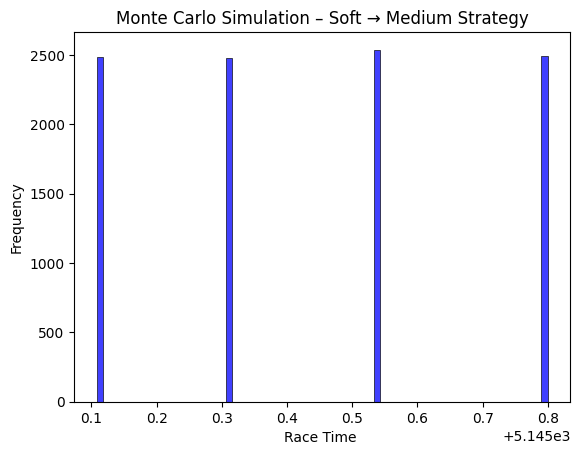

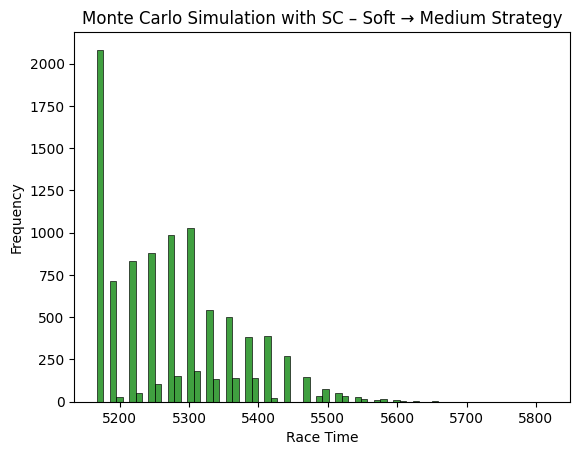

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Block: Histograms
# 1) Histogram of Monte Carlo simulations for the Soft → Medium strategy
# Run 10,000 simulations with run_monte_carlo_soft_medium function, then plot distribution of total race times
A = sns.histplot(run_monte_carlo_soft_medium(), bins=70, color="blue")
A.set_xlabel("Race Time (s)")      # X-axis: total race time in seconds
A.set_ylabel("Frequency")          # Y-axis: how many simulations fall in each bin
A.set_title("Monte Carlo Simulation – Soft → Medium Strategy")
plt.savefig("M.C.Simulation – Soft → Medium Strategy.png")  # Save the histogram as a PNG file
plt.show()  # Display histogram interactively

# 2) Histogram of Monte Carlo simulations with Safety Car
# Run 10,000 simulations with run_monte_carlo_soft_medium_SC function, then plot distribution of total race times
B = sns.histplot(run_monte_carlo_soft_medium_SC(), bins=70, color="green")
B.set_xlabel("Race Time (s)")      # X-axis: total race time in seconds
B.set_ylabel("Frequency")          # Y-axis: how many simulations fall in each bin
B.set_title("Monte Carlo Simulation with SC – Soft → Medium Strategy")
plt.savefig("M.C.Simulation with SC – Soft → Medium Strategy.png")  # Save plot with SC
plt.show()  # Display histogram interactively